In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
audio_files_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls -ltra '{audio_files_dir}'/.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgulo_gRskKGz7m1zUSMZbA0083c1vu1WUIoDn1D7UlWOR7W0Q1K7Y
Mounted at /content/gdrive
ls: '/content/gdrive/My Drive/UpworkNotebooks/Opera Files//./Audios': No such file or directory
total 28
lrw------- 1 root root    0 May  1 02:47 Audios -> /content/gdrive/.shortcut-targets-by-id/1DOvML8hO7v6XEq5-HQAQSv

#Data Preprocessing

In [ ]:
!pip install -q librosa
!pip install -q tensorflow_io
!pip install -q pysoundfile
!pip install -q -U keras-tuner

     |████████████████████████████████| 22.7 MB 1.9 MB/s 
     |████████████████████████████████| 2.1 MB 43.8 MB/s 
     |████████████████████████████████| 97 kB 3.2 MB/s 


In [ ]:
import os
import librosa

from IPython import display
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio


import keras_tuner as kt
from ast import literal_eval

import time
%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib.colors import LogNorm
from PIL import Image

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.applications import vgg16, vgg19
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
#creating data directories.
#if already present, ignore

base_dir = audio_files_dir + 'Chollet_Data/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

paths = [base_dir, train_dir, validation_dir, test_dir]

for path in paths:
  if os.path.exists(path)==False:
    print('Creating this directory: ', path)
    !mkdir "{path}"



#!mkdir '{base_dir}' "{train_dir}" '{validation_dir}' '{test_dir}'


In [ ]:
#reading file paths and creating 
data = pd.read_csv(audio_files_dir + "file_paths_male_only.csv")
#scramble the data
data = data.sample(frac=1)
#display data
data.head()


,path,subregister,Target
313,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Baritones_Dramatic,1
1630,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Tenor_Lyric,7
175,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Baritones_Lyric,0
1210,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Tenor_Spinto,5
251,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Baritones_Dramatic,1


In [ ]:
#split the data into train, test and validation
def data_splits(data, test_split, val_split):
  '''creating the train, validation and test sets'''
  assert test_split < 0.5
  assert val_split < 0.5

  len_data = len(data)
  
  test_inv  = int(round(1/test_split))
  val_inv = int(round(1/val_split))
  
  x_data = data[len_data//test_inv:]
  test_data = data[0:len_data//test_inv]
  val_data = x_data[0:len(x_data)//val_inv]
  train_data = x_data[len(x_data)//val_inv:]

  print('Total data samples: ', len_data)
  print('Train samples: ', len(train_data))
  print('Validation samples: ', len(val_data))
  print('Test samples: ', len(test_data))

  return [train_data, test_data, val_data]

In [ ]:

def mfccs_to_dir(dataset, base_dir):
  train, test, validation = dataset
  dataset = [train, test, validation]
  dataset_names = ['train', 'test', 'validation']

  for subregister in train['subregister'].unique():
    for sub_directory in os.listdir(base_dir):
      new_dir = base_dir + '{}/'.format(sub_directory) + '{}'.format(subregister)
      print(os.path.basename(new_dir))
      !mkdir '{new_dir}'
  
  for i in range(len(dataset_names)):
    for file_name in dataset[i]['path']:
      sub_directory = os.path.basename(os.path.dirname(file_name))
      # print(sub_directory)
      new_dir = base_dir + '{}/'.format(dataset_names[i]) + '{}'.format(sub_directory)
      # print(new_dir)
      audio, sample_rate = librosa.load(file_name) 
      mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)

      try:
        array = np.reshape(mfccs, (128, 259))
      except ValueError:
        pass
      data = Image.fromarray(array)
      data = data.convert('RGB')
      data.save(new_dir + '/{}.png'.format(os.path.basename(file_name)))

    # mfccs_processed = np.mean(mfccs.T,axis=0)
    # mfccs_processed = list(mfccs_processed)
  # return image
  pass


dataset = data_splits(data, 0.1, 0.1)
mfccs_to_dir(dataset, base_dir)

Total data samples:  1878
Train samples:  1522
Validation samples:  169
Test samples:  187
Tenor_Dramatic
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Chollet_Data/train/Tenor_Dramatic’: File exists
Tenor_Dramatic
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Chollet_Data/validation/Tenor_Dramatic’: File exists
Tenor_Dramatic
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Chollet_Data/test/Tenor_Dramatic’: File exists
Tenor_Spinto
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Chollet_Data/train/Tenor_Spinto’: File exists
Tenor_Spinto
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Chollet_Data/validation/Tenor_Spinto’: File exists
Tenor_Spinto
mkdir: cannot create directory ‘/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Chollet_Data/test/Tenor_Spinto’: File exists
Tenor_Leggero
mkdir: cann

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [ ]:
#Sanity Check

len(os.listdir(test_dir + '/Tenor_Dramatic'))


22

In [ ]:
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3), )
# conv_base2 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=)


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

##Data augmentation


In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import  RMSprop

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20,
                                                    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20,
                                                        class_mode='categorical')



Found 1522 images belonging to 9 classes.
Found 169 images belonging to 9 classes.


In [ ]:
#freezing the convolutional base
conv_base.trainable=False

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.01), metrics=['acc'])
history = model.fit(train_generator, steps_per_epoch=10, epochs=15,validation_data=validation_generator)


Epoch 1/15
10/10 [==============================] - ETA: 0s - loss: 39.6983 - acc: 0.0500

KeyboardInterrupt: ignored

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count, 9))
  
  generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size,
                                          class_mode='categorical')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 1522)
validation_features, validation_labels = extract_features(validation_dir, 169)
test_features, test_labels = extract_features(test_dir, 187)

Found 1522 images belonging to 9 classes.


KeyboardInterrupt: ignored

In [ ]:
print(len(train_labels))

1522


In [ ]:
train_features = np.reshape(train_features, (1522, 4 * 7 * 512))
validation_features = np.reshape(validation_features, (169, 4 * 7 * 512))
test_features = np.reshape(test_features, (187, 4 * 7 * 512))

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import  RMSprop

# model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(9, activation='softmax'))
# model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc'])
# history = model.fit(train_features, train_labels, epochs=500, batch_size=20, 
#                     validation_data=(validation_features, validation_labels))

def create_new_model():  
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4 * 4 * 512), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(336, activation='relu', kernel_regularizer=l2(0.006)),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(472, activation='relu', kernel_regularizer=l2(0.006)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
  ], name='model_mk3')
  return model

model_mk3 = create_new_model()
model_mk3.summary()



Model: "model_mk3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 336)               2752848   
_________________________________________________________________
dropout_12 (Dropout)         (None, 336)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 472)               159064    
_________________________________________________________________
dropout_13 (Dropout)         (None, 472)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 9)                 4257      
Total params: 2,916,169
Trainable params: 2,916,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_mk3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(train_features, train_labels, epochs=200, batch_size=20, 
                    validation_data=(validation_features, validation_labels))

TypeError: ignored

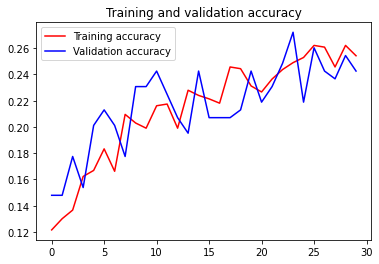

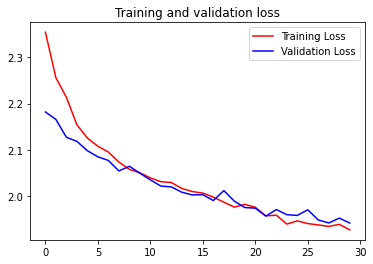

In [ ]:
def model_performance(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  pass

model_performance(history)

